# Data Augmentation
MNIST is a dataset of grayscale images of handwritten digits, released by the National Institute of Standards and Technology.

I'll give you the code to build a softmax regression model, but feel free to throw something more interesting in there.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

import sklearn.decomposition

%matplotlib inline
from IPython.core.pylabtools import figsize

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.__version__

'1.5.0'

## Load the dataset

TensorFlow comes with some convenience functions for loading the train and test sets.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

Edit the `"data/"` to wherever you hid the files.

In [4]:
mnist = input_data.read_data_sets("data/")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [5]:
N = 250
train_images = mnist.train.images[:N,:]
train_labels = mnist.train.labels[:N]

# split into 10 batches
train_image_batches = np.array_split(train_images, 10)
train_label_batches = np.array_split(train_labels, 10)

In [6]:
mnist.train.labels[:10]

array([7, 3, 4, 6, 1, 8, 1, 0, 9, 8], dtype=uint8)

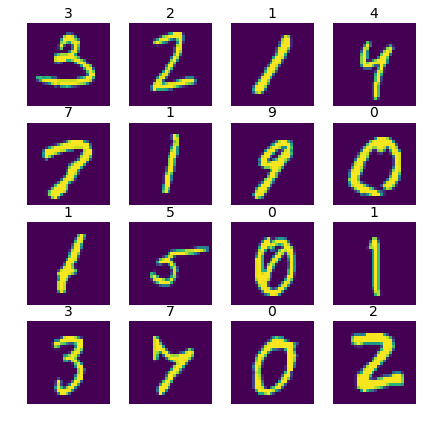

In [7]:
figsize(7,7)
#num_train = mnist.train.images.shape[0]

for i in range(16):
    plt.subplot(4,4,i+1)
    # pick a training example
    example = np.random.choice(np.arange(N))
    # plot the image
    plt.imshow(train_images[example,:].reshape((28,28)), interpolation="none")
    plt.axis("off")
    # label with the correct answer
    plt.title(train_labels[example], fontsize=14);

In [156]:
def train(numsteps=1000, train_batches=train_image_batches, testims=mnist.test.images):
    # create an empty array to hold test accuracy at each step
    test_acc = np.zeros(numsteps)

    # create a session to run in
    with tf.Session() as sess:
        # initialize variables
        sess.run(tf.global_variables_initializer())
        # for each training step
        for i in tqdm(range(numsteps)):
            # for each batch
            for x_batch,y_batch in zip(train_batches, train_label_batches):
                sess.run(train_step, feed_dict={x:x_batch, y_:y_batch, is_training:1})
            # once per epoch check the test accuracy
            test_acc[i] = sess.run(accuracy, 
                                   feed_dict={x:testims,y_:mnist.test.labels,
                                             is_training:0})
        
    plt.plot(test_acc, lw=2)
    plt.grid("on")
    plt.xlabel("training epoch", fontsize=14)
    plt.ylabel("test accuracy", fontsize=14)
    plt.title("Final accuracy: %s"%round(test_acc[-1],4))

## Build the model

### Get the data in

For this example, we'll manually load the data in one batch at a time. For grown-up machine learning problems TensorFlow has some really powerful tools for loading, shuffling, and augmenting data for the next batch on your CPU while your GPU chugs away on the last batch.

For now, though- we'll make placeholders to input a batch of images and a batch of corresponding labels, and an operation to convert the labels to one-hot encoding.

In [38]:
tf.reset_default_graph()

In [39]:
num_hidden = 25
num_classes = 10
learnrate = 0.01
momentum = 0.9


x = tf.placeholder(tf.float32, [None, 784], name="data_placeholder")
y_ = tf.placeholder(tf.int32, [None,], name="label_placeholder")
is_training = tf.placeholder_with_default(1, []) # we'll need this later

y_oh = tf.one_hot(y_, 10, name="labels_one_hot")

W1 = tf.Variable(tf.random_normal([784, num_hidden], 0, 0.01))
b1 = tf.Variable(tf.zeros([num_hidden]))
y1 = tf.matmul(x,W1) + b1
hidden = tf.sigmoid(y1)

W2 = tf.Variable(tf.random_normal([num_hidden, num_classes], 0, 0.01))
b2 = tf.Variable(tf.zeros([num_classes]))
y2 = tf.matmul(hidden,W2) + b2
output = tf.sigmoid(y2)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits=y2))
optimizer = tf.train.MomentumOptimizer(learnrate, momentum)
train_step = optimizer.minimize(cross_entropy)

prediction = tf.argmax(y2,1)
correct_prediction = tf.equal(prediction, tf.argmax(y_oh,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

100%|██████████| 1000/1000 [00:30<00:00, 32.98it/s]


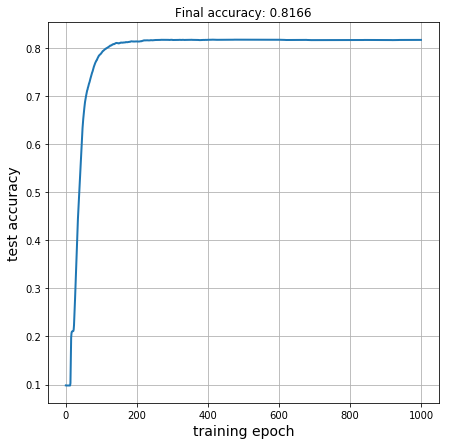

In [40]:
train()

## Noise injection at weights

In [43]:
tf.reset_default_graph()

In [44]:
num_hidden = 25
num_classes = 10
learnrate = 0.01
momentum = 0.9

epsilon = 0.1   # <-----------------

x = tf.placeholder(tf.float32, [None, 784], name="data_placeholder")
y_ = tf.placeholder(tf.int32, [None,], name="label_placeholder")
is_training = tf.placeholder_with_default(1., []) 

y_oh = tf.one_hot(y_, 10, name="labels_one_hot")

W1 = tf.Variable(tf.random_normal([784, num_hidden], 0, 0.01))
noise1 = is_training*tf.random_normal([784, num_hidden], 0, epsilon)   # <-----------------
b1 = tf.Variable(tf.zeros([num_hidden]))
y1 = tf.matmul(x,W1+noise1) + b1   # <-----------------
hidden = tf.sigmoid(y1)

W2 = tf.Variable(tf.random_normal([num_hidden, num_classes], 0, 0.01))
noise2 = is_training*tf.random_normal([num_hidden, num_classes], 0, epsilon)   # <-----------------
b2 = tf.Variable(tf.zeros([num_classes]))
y2 = tf.matmul(hidden,W2+noise2) + b2   # <-----------------
output = tf.sigmoid(y2)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits=y2))
optimizer = tf.train.MomentumOptimizer(learnrate, momentum)
train_step = optimizer.minimize(cross_entropy)

prediction = tf.argmax(y2,1)
correct_prediction = tf.equal(prediction, tf.argmax(y_oh,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

100%|██████████| 1000/1000 [00:34<00:00, 29.18it/s]


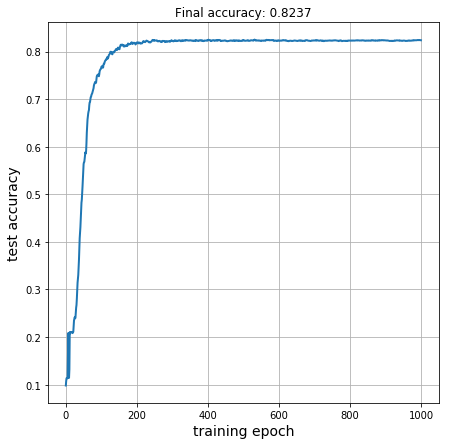

In [46]:
train()

## Image augmentation

In [121]:
tf.reset_default_graph()

In [122]:
num_hidden = 25
num_classes = 10
learnrate = 0.01
momentum = 0.9


x = tf.placeholder(tf.float32, [None, 784], name="data_placeholder")
y_ = tf.placeholder(tf.int32, [None,], name="label_placeholder")
is_training = tf.placeholder_with_default(1., []) 

x_aug = tf.reshape(x, [-1, 28, 28]) # <-----------------
x_aug = tf.image.random_brightness(x_aug, 0.1) # <-----------------
x_aug = tf.image.random_contrast(x_aug, 0.9, 1.1) # <-----------------
x_aug = tf.reshape(x_aug, [-1, 784]) # <-----------------
x_prep = is_training*x_aug + (1-is_training)*x # <-----------------

y_oh = tf.one_hot(y_, 10, name="labels_one_hot")

W1 = tf.Variable(tf.random_normal([784, num_hidden], 0, 0.01))
b1 = tf.Variable(tf.zeros([num_hidden]))
y1 = tf.matmul(x_prep,W1) + b1 
hidden = tf.sigmoid(y1)

W2 = tf.Variable(tf.random_normal([num_hidden, num_classes], 0, 0.01))
b2 = tf.Variable(tf.zeros([num_classes]))
y2 = tf.matmul(hidden,W2) + b2  
output = tf.sigmoid(y2)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits=y2))
optimizer = tf.train.MomentumOptimizer(learnrate, momentum)
train_step = optimizer.minimize(cross_entropy)

prediction = tf.argmax(y2,1)
correct_prediction = tf.equal(prediction, tf.argmax(y_oh,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

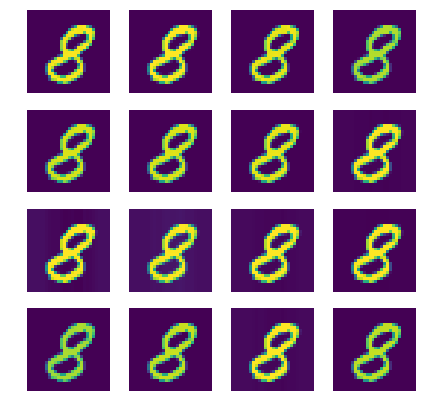

In [123]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(16):
        plt.subplot(4,4,i+1)
        augmented = sess.run(x_aug, feed_dict={x:train_images[5,:].reshape(1,-1)})
        plt.imshow(augmented.reshape((28,28)), vmin=0, vmax=1)
        plt.axis("off")

100%|██████████| 1000/1000 [01:17<00:00, 12.98it/s]


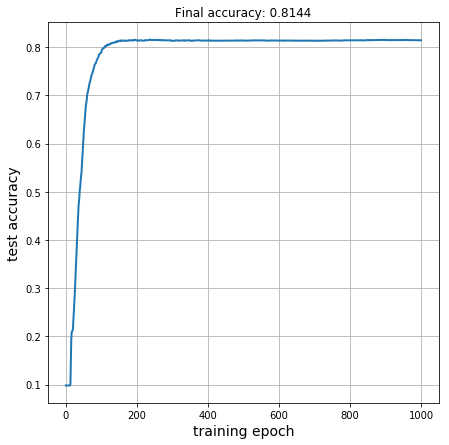

In [124]:
train()

In [218]:
tf.reset_default_graph()

In [219]:
num_hidden = 150
learnrate = 0.1
momentum = 0.9

x = tf.placeholder(tf.float32, [None, 784], name="data_placeholder")
net = x

num_hidden = [784, 350, 784]
for i in range(1, len(num_hidden)):
    W = tf.Variable(tf.random_normal([num_hidden[i-1], num_hidden[i]], 0, 0.01))
    b = tf.Variable(tf.zeros([num_hidden[i]]))
    y = tf.matmul(net,W) + b
    net = tf.nn.relu(y)
    if num_hidden[i] == 350:
        hidden = net

#W2 = tf.Variable(tf.random_normal([num_hidden, 784], 0, 0.01))
#b2 = tf.Variable(tf.zeros([784]))
#y2 = tf.matmul(hidden,W2) + b2
#output = tf.sigmoid(y2)
output = tf.sigmoid(y)

loss = tf.reduce_mean((output - x)**2)
optimizer = tf.train.MomentumOptimizer(learnrate, momentum)
train_step = optimizer.minimize(loss)

In [ ]:
numsteps = 250
reconstruction_error = np.zeros(numsteps)
with tf.Session() as sess:
    # initialize variables
    sess.run(tf.global_variables_initializer())
    # for each training step
    for i in tqdm(range(numsteps)):
            # for each batch
            _, reconstruction_error[i] = sess.run([train_step, loss], 
                                                  feed_dict={x:mnist.train.images[:25000,:]})
    
    # while we're here, compute the dense representations for our
    # training and test sets
    train_vector_batches = []
    for t in train_image_batches:
        train_vector_batches.append(sess.run(hidden, feed_dict={x:t}))
    test_vectors = sess.run(hidden, feed_dict={x:mnist.test.images})
plt.plot(reconstruction_error, lw=2)
plt.grid("on")
plt.xlabel("training epoch", fontsize=14)
plt.ylabel("reconstruction error", fontsize=14);

 83%|████████▎ | 207/250 [10:22<02:09,  3.00s/it]

In [ ]:
test_vectors.shape

In [ ]:
tf.reset_default_graph()

In [215]:
embedding_dimension = 350
num_hidden = 25
num_classes = 10
learnrate = 0.01
momentum = 0.9


x = tf.placeholder(tf.float32, [None, embedding_dimension], name="data_placeholder") # <--------------
y_ = tf.placeholder(tf.int32, [None,], name="label_placeholder")
is_training = tf.placeholder_with_default(1, []) # we'll need this later

y_oh = tf.one_hot(y_, 10, name="labels_one_hot")

W1 = tf.Variable(tf.random_normal([embedding_dimension, num_hidden], 0, 0.01))  # <--------------
b1 = tf.Variable(tf.zeros([num_hidden]))
y1 = tf.matmul(x,W1) + b1
hidden = tf.sigmoid(y1)

W2 = tf.Variable(tf.random_normal([num_hidden, num_classes], 0, 0.01))
b2 = tf.Variable(tf.zeros([num_classes]))
y2 = tf.matmul(hidden,W2) + b2
output = tf.sigmoid(y2)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits=y2))
optimizer = tf.train.MomentumOptimizer(learnrate, momentum)
train_step = optimizer.minimize(cross_entropy)

prediction = tf.argmax(y2,1)
correct_prediction = tf.equal(prediction, tf.argmax(y_oh,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

100%|██████████| 1000/1000 [00:20<00:00, 47.94it/s]


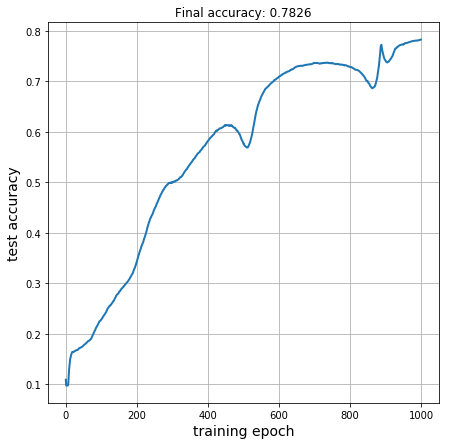

In [216]:
train(1000, train_batches=train_vector_batches, testims=test_vectors)